# Title I Allocations w/ DP ACS

## Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [19]:
%load_ext autoreload
%autoreload 2

from dp_policy.titlei.utils import get_sppe
import pandas as pd

sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,state,ppe,abbrv
0,Alabama,9697,AL
1,Alaska,17726,AK
2,American Samoa,NaN,AS
3,Arizona,8296,AZ
4,Arkansas,10072,AR


Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

Also, a method for roughly estimating standard errors for the SAIPE estimates, based on [these published docs](https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html). This could be improved - but start with this as a shortcut.

In [20]:
from dp_policy.titlei.utils import get_saipe

saipe = get_saipe("../data/saipe19.xls")
saipe.head()

State Postal Code  \
State FIPS Code District ID                     
1               190                        AL   
                5                          AL   
                30                         AL   
                60                         AL   
                90                         AL   

                                                            Name  \
State FIPS Code District ID                                        
1               190               Alabaster City School District   
                5               Albertville City School District   
                30           Alexander City City School District   
                60                Andalusia City School District   
                90                 Anniston City School District   

                             Estimated Total Population  \
State FIPS Code District ID                               
1               190                               34669   
                5                                 22051   
                30                                16920   
                60                                 8842   
                90                                22043   

                             Estimated Population 5-17  \
State FIPS Code District ID                              
1               190                               6710   
                5                                 4131   
                30                                2575   
                60                                1465   
                90                                3065   

                             Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder  \
State FIPS Code District ID                                                                                                          
1               190                                                        649                                                       
                5                                                          957                                                       
                30                                                         703                                                       
                60                                                         406                                                       
                90                                                        1057                                                       

                             median_cv  
State FIPS Code District ID             
1               190               0.23  
                5                 0.23  
                30                0.28  
                60                0.35  
                90                0.23

In [61]:
# average school district student pop
saipe["Estimated Population 5-17"].mean()
saipe["Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"].mean()

645.2559921116505

### Code

In [21]:
from dp_policy.titlei.mechanisms import GroundTruth

Next, a class for the different ways we might allocate funds based on the poverty estimates (e.g. Abowd's shortcut method vs. the full Sonnenberg method).

In [22]:
from dp_policy.titlei.allocators import AbowdAllocator, SonnenbergAuthorizer
from dp_policy.titlei.utils import weighting

weighting(1559, 10000)

1993.0

Finally, the main method for computing estimates, then grant amounts.

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


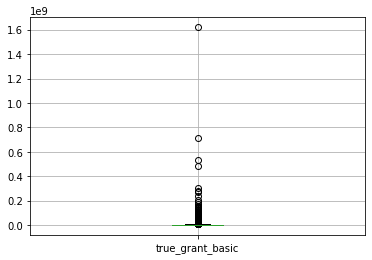

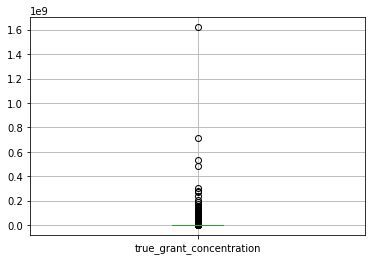

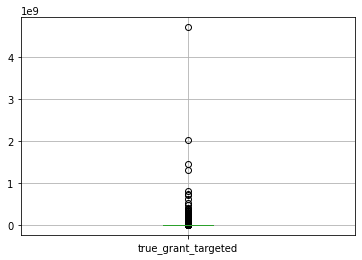

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from dp_policy.api import titlei_funding as funding

# Test with ground truth mechanism
grants = funding(saipe, SonnenbergAuthorizer, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"), weighting)
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Laplace
### Data
From [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) release.

### Mechanism

In [24]:
from dp_policy.titlei.mechanisms import Laplace
        
Laplace(saipe, 0.1, 0).poverty_estimates()

(State FIPS Code  District ID
 1                190            3.465547e+04
                  5              2.206296e+04
                  30             1.691594e+04
                  60             8.827192e+03
                  90             2.203867e+04
                                     ...     
 56               6240           7.136465e+03
                  5820           6.698265e+02
                  4830           5.476493e+03
                  6090           1.462038e+03
 72               30             3.193678e+06
 Name: Estimated Total Population, Length: 13184, dtype: float64,
 State FIPS Code  District ID
 1                190              6697.066145
                  5                4137.116199
                  30               2579.860843
                  60               1460.986661
                  90               3037.582470
                                     ...      
 56               6240             1292.943809
                  5820               92

### Results
First, using the full Sonnenberg authorization algo.

In [25]:
grants = funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 5, 0), get_sppe("../data/sppe18.xlsx"), weighting)
grants.describe()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


,true_pop_total,true_children_total,true_children_poverty,median_cv,est_pop_total,est_children_total,est_children_poverty,true_children_eligible,est_children_eligible,sppe,true_grant_basic,true_grant_concentration,true_grant_targeted,est_grant_basic,est_grant_concentration,est_grant_targeted
count,1.318200e+04,1.318200e+04,13182.000000,13182.000000,1.318200e+04,1.318200e+04,13182.000000,13182.000000,13182.000000,13182.000000,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04
mean,2.651938e+04,4.049290e+03,625.253224,0.383360,2.651938e+04,4.049291e+03,625.254630,625.253224,625.254630,13027.845092,3.026463e+06,2.231939e+06,5.062192e+06,3.026325e+06,2.231735e+06,5.062103e+06
std,1.155746e+05,1.728792e+04,3467.140325,0.171494,1.155746e+05,1.728793e+04,3467.144012,3467.140325,3467.144012,3667.794832,1.912444e+07,1.908713e+07,5.239813e+07,1.912449e+07,1.908717e+07,5.239820e+07
min,0.000000e+00,0.000000e+00,0.000000,0.150000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,7525.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.802000e+03,4.260000e+02,52.000000,0.230000,2.801929e+03,4.260899e+02,52.124619,52.000000,52.124619,10157.000000,2.617935e+05,0.000000e+00,1.924048e+05,2.612000e+05,0.000000e+00,1.933030e+05
50%,7.911000e+03,1.186000e+03,147.000000,0.350000,7.911011e+03,1.186101e+03,147.264010,147.000000,147.264010,12159.000000,7.504039e+05,0.000000e+00,7.283281e+05,7.501486e+05,0.000000e+00,7.276223e+05
75%,2.101825e+04,3.222000e+03,411.000000,0.420000,2.101826e+04,3.222193e+03,410.982816,411.000000,410.982816,15780.000000,2.076117e+06,9.130432e+05,2.294255e+06,2.076502e+06,9.125354e+05,2.293482e+06
max,8.336817e+06,1.193045e+06,259012.000000,0.670000,8.336817e+06,1.193045e+06,259012.220921,259012.000000,259012.220921,22845.000000,1.619697e+09,1.619697e+09,4.714287e+09,1.619698e+09,1.619698e+09,4.714291e+09


In [104]:
import itertools

def test_params(mech, eps=list(np.logspace(-3, 1)) + [2.5], delta=[0.0]):
    allocations = []
    print(f"{len(eps)*len(delta)} iters:")
    i = 0
    for d in delta:
        for e in eps:
            print(i, end=" ")
            i += 1
            allocations.append(funding(
                saipe, 
                SonnenbergAuthorizer, 
                mech(saipe, e, d), 
                get_sppe("../data/sppe18.xlsx"), 
                weighting, 
                verbose=False)
            )
    return pd.concat(allocations, axis=0, join="inner", keys=itertools.product(delta, eps), names=["delta", "epsilon", "id"])

def plot_results(results):
    results["true_grant_total"] = results["true_grant_basic"] + results["true_grant_concentration"] + results["true_grant_targeted"]
    results["est_grant_total"] = results["est_grant_basic"] + results["est_grant_concentration"] + results["est_grant_targeted"]
    
    eps, allocations = list(zip(*results.groupby("epsilon")))
    
    mse = []
    
    for e, alloc in results.groupby("epsilon"):
        for grant_type in ("basic", "concentration", "targeted", "total"):
            error = alloc[f"true_grant_{grant_type}"] - alloc[f"est_grant_{grant_type}"]
            error_prop = alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])\
                - alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"])
            if (e == 2.5) or (e > 0.1 and e < 0.11):
                print(f"## {grant_type} grants ##")
                print(f"RMSE at eps={e}:", np.sqrt(np.mean(error**2)))
                print(f"RMSE prop eps={e}:", sum(abs(error_prop)))
                print(f"Total misalloc at eps={e}:", sum(abs(error)))
                print("Total true alloc:", sum(alloc[f"true_grant_{grant_type}"]))
        
            if grant_type == "total":
                mse.append(np.sqrt(sum(error**2)/alloc.shape[0]))
    
    grant_type = "total"
    plt.plot(eps, mse)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel("Epsilon")
    plt.ylabel(f"{grant_type} grant RMSE, nationally")
    plt.show()

    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc = alloc.sort_values(f"true_grant_{grant_type}")
        ids = alloc.index.get_level_values("id").astype('str')
        plt.scatter(ids, alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]), s=2, alpha=0.3, label=f"eps={e}")
    plt.scatter(ids, alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), s=2, alpha=0.3, label="true")
    ax = plt.gca()
    ax.legend()
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Allocation as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()

    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6
        plt.scatter(alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), alloc.err_prop, s=3, alpha=0.4, label=f"eps={e}")
    ax = plt.gca()
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel("True allocation as % of total")
    plt.ylabel("Misallocation per million as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()

test_params(Laplace, eps=[0.1, 1.0], delta=[0.0]).head()

2 iters:
0 1 

State Postal Code                                 Name  \
delta epsilon id                                                          
0.0   0.1     0                 AL       Alabaster City School District   
              1                 AL     Albertville City School District   
              2                 AL  Alexander City City School District   
              3                 AL       Andalusia City School District   
              4                 AL        Anniston City School District   

                  true_pop_total  true_children_total  true_children_poverty  \
delta epsilon id                                                               
0.0   0.1     0            34669                 6710                    649   
              1            22051                 4131                    957   
              2            16920                 2575                    703   
              3             8842                 1465                    406   
              4            22043                 3065                   1057   

                  median_cv  est_pop_total  est_children_total  \
delta epsilon id                                                 
0.0   0.1     0        0.23   34670.025479         6710.843943   
              1        0.23   22036.138468         4131.734890   
              2        0.28   16910.553883         2562.646227   
              3        0.35    8865.264492         1465.870260   
              4        0.23   22046.237986         3055.754737   

                  est_children_poverty  true_children_eligible  \
delta epsilon id                                                 
0.0   0.1     0             640.631740                     649   
              1             981.180586                     957   
              2             709.760438                     703   
              3             395.413408                     406   
              4            1050.703103                    1057   

                  est_children_eligible    sppe  true_grant_basic  \
delta epsilon id                                                    
0.0   0.1     0              640.631740  9697.0      2.705623e+06   
              1              981.180586  9697.0      3.989647e+06   
              2              709.760438  9697.0      2.930744e+06   
              3              395.413408  9697.0      1.692578e+06   
              4             1050.703103  9697.0      4.406538e+06   

                  true_grant_concentration  true_grant_targeted  \
delta epsilon id                                                  
0.0   0.1     0               0.000000e+00         2.705623e+06   
              1               3.989647e+06         5.091282e+06   
              2               2.930744e+06         4.276260e+06   
              3               1.692578e+06         2.490924e+06   
              4               4.406538e+06         7.792736e+06   

                  est_grant_basic  est_grant_concentration  est_grant_targeted  
delta epsilon id                                                                
0.0   0.1     0      2.670736e+06             0.000000e+00        2.670736e+06  
              1      4.090454e+06             4.090454e+06        5.343299e+06  
              2      2.958928e+06             2.958928e+06        4.362352e+06  
              3      1.648443e+06             1.648443e+06        2.377461e+06  
              4      4.380287e+06             4.380287e+06        7.726180e+06

In [ ]:
results = test_params(Laplace)
results.to_csv("../results/titlei_laplace.csv")

In [105]:
results = pd.read_csv("../results/titlei_laplace.csv").set_index(['delta', 'epsilon', 'id'])
plot_results(results)

AttributeError: 'DataFrame' object has no attribute 'true_allocation'

### Sanity check: using Abowd's method

Abowd reported a mean squared SPPE of 20 million from 2014-15 data.

In [87]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting)
print("Mean Sq. SPPE (2018):", np.mean(grants.adj_sppe**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
Mean Sq. SPPE (2018): 26235395.69087739


They also report an RMSE at e=2.52 of 2509 (again, using 2014-15 Common Core data, which I can't replicate) and 1334 at e=4.74 and 63000 at e=0.1. 

In [88]:
# RMSE
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

2822.585025170781

In [89]:
print("Total misalloc at eps=2.52:", sum(abs(error)))

Total misalloc at eps=2.52: 25929871.380407613


In [90]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 4.74, 0), get_sppe("../data/sppe18.xlsx"), weighting)
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


1526.0243397167562

In [32]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 0.1, 0), get_sppe("../data/sppe18.xlsx"), weighting)
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


70920.54577742063

So we get some small differences due to inflation or due to other differences in data, but roughly the same values. Biggest difference is in SPPE - apparenlty spending has increased since 2014.

### Uncertainty

The simplest approximate measure of uncertainty is given by the Census's median coefficient of varation in the poverty estimates for each district. We can construct a confidence interval for each allocation as follows, ignoring variance due to missing cutoffs (for now) by using the Abowd method.

In [92]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting)
grants.head()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


,State Postal Code,Name,true_pop_total,true_children_total,true_children_poverty,median_cv,est_pop_total,est_children_total,est_children_poverty,true_children_eligible,est_children_eligible,sppe,adj_sppe,true_allocation,est_allocation
0,AL,Alabaster City School District,34669,6710,649,0.23,34669.813999,6710.576379,650.080151,649,650.080151,9697.0,4168.910429,2.705623e+06,2.710126e+06
1,AL,Albertville City School District,22051,4131,957,0.23,22050.835911,4130.596472,957.022015,957,957.022015,9697.0,4168.910429,3.989647e+06,3.989739e+06
2,AL,Alexander City City School District,16920,2575,703,0.28,16920.140450,2574.014167,703.213691,703,703.213691,9697.0,4168.910429,2.930744e+06,2.931635e+06
3,AL,Andalusia City School District,8842,1465,406,0.35,8842.064547,1464.641108,406.358989,406,406.358989,9697.0,4168.910429,1.692578e+06,1.694074e+06
4,AL,Anniston City School District,22043,3065,1057,0.23,22043.247735,3065.726731,1056.209155,1057,1056.209155,9697.0,4168.910429,4.406538e+06,4.403241e+06


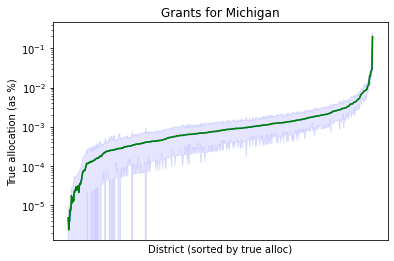

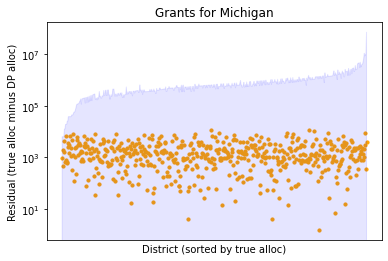

In [103]:
def plot_uncertainty(grants):
    grants = grants[grants["State Postal Code"] == "MI"].sort_values("true_allocation")
    x = grants.index.astype('str')
    y = grants.true_allocation / sum(grants.true_allocation)
    plt.plot(x, y)
    ax = plt.gca()
    prop_ci = 1.96 * grants.median_cv * y
    ax.fill_between(x, (y-prop_ci), (y+prop_ci), color='b', alpha=0.1)

    plt.plot(x, grants.est_allocation / sum(grants.est_allocation), color='green')

    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("True allocation (as %)")
    plt.title(f"Grants for Michigan")
    plt.show()
    
    y = np.abs(grants.true_allocation - grants.est_allocation)
    plt.scatter(x, y, s=10, color='orange')

    ax = plt.gca()
    ci = 1.96 * grants.median_cv * grants.true_allocation
    ax.fill_between(x, ci, color='b', alpha=0.1)

    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Residual (true alloc minus DP alloc)")
    plt.title(f"Grants for Michigan")
    plt.show()

plot_uncertainty(grants)

## Gaussian (Advanced Composition, Approx. DP)

Add Gaussian noise ln(1/delta)/epsilon for better accuracy bound.

In [ ]:
from dp_policy.titlei.mechanisms import Gaussian

# with delta = 0
results = test_params(
    Gaussian, 
    eps=list(np.logspace(-3, 0)), 
    delta=list(np.linspace(0.02, 1, endpoint=False, num=10))
)
results.to_csv("../results/titlei_gaussian.csv")

In [37]:
results = pd.read_csv("../results/titlei_gaussian.csv").set_index(['delta', 'epsilon', 'id'])

0.02
## basic grants ##
RMSE at eps=0.1048113134154685: 136578.34581085687
RMSE prop eps=0.1048113134154685: 0.03553093066957835
Total misalloc at eps=0.1048113134154685: 1405938738.0254703
Total true alloc: 39894838662.272514


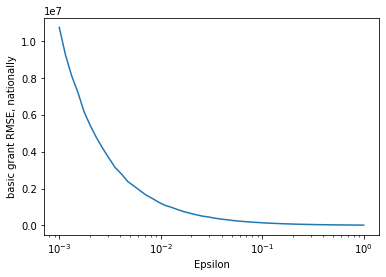

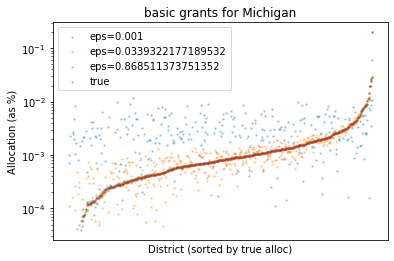

<ipython-input-52-2e9fc111efa2>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


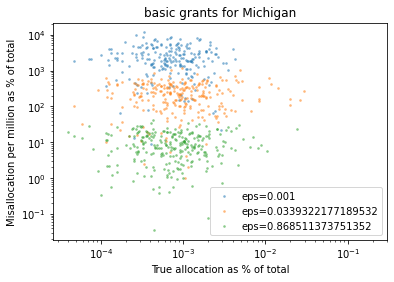

## concentration grants ##
RMSE at eps=0.1048113134154685: 404589.0624087916
RMSE prop eps=0.1048113134154685: 0.05486343977774475
Total misalloc at eps=0.1048113134154685: 1515214400.9540806
Total true alloc: 29421416873.03583


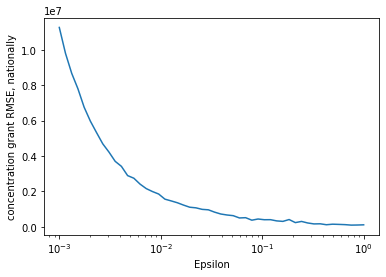

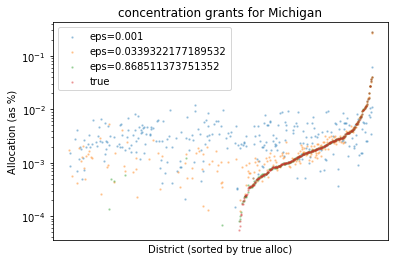

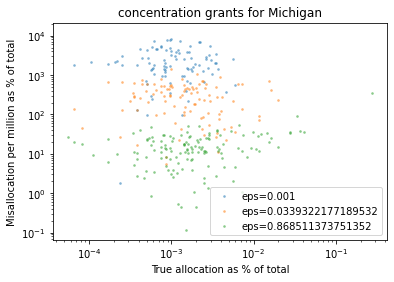

## targeted grants ##
RMSE at eps=0.1048113134154685: 279639.7495870192
RMSE prop eps=0.1048113134154685: 0.0379142137002709
Total misalloc at eps=0.1048113134154685: 2371409058.6325836
Total true alloc: 66729811774.698265


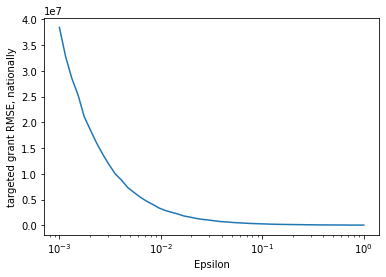

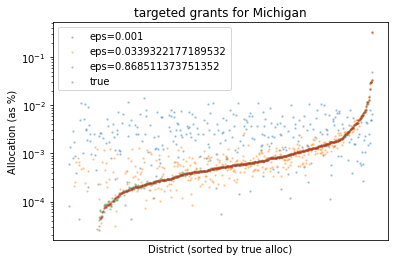

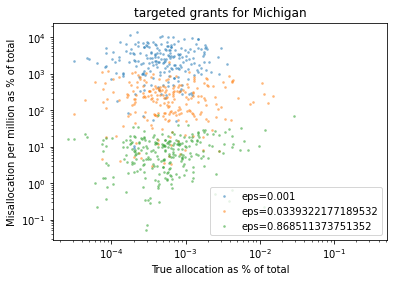

In [56]:
print(results.index.get_level_values('delta')[0])
plot_results(results.xs(results.index.get_level_values('delta')[0], level='delta'))

## basic grants ##
RMSE at eps=0.1048113134154685: 46191.10530918266
RMSE prop eps=0.1048113134154685: 0.011857805721293158
Total misalloc at eps=0.1048113134154685: 472339382.17725414
Total true alloc: 39894838662.272514


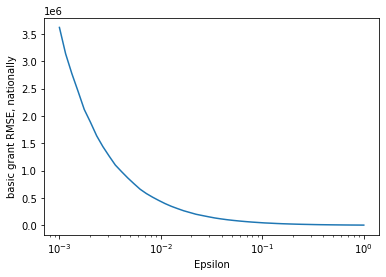

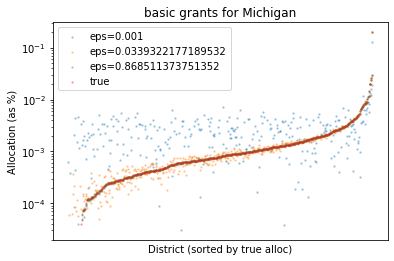

<ipython-input-52-2e9fc111efa2>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


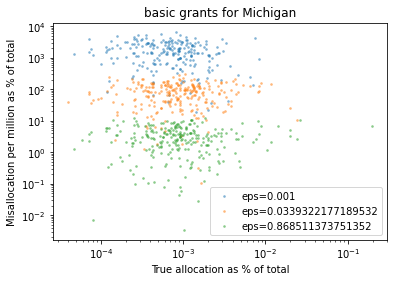

## concentration grants ##
RMSE at eps=0.1048113134154685: 164688.44996267467
RMSE prop eps=0.1048113134154685: 0.016486066332224884
Total misalloc at eps=0.1048113134154685: 482483117.5341025
Total true alloc: 29421416873.03583


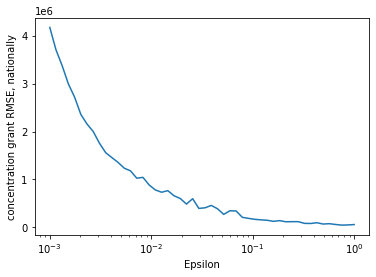

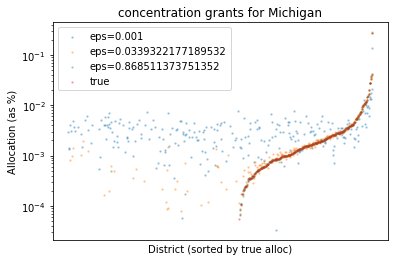

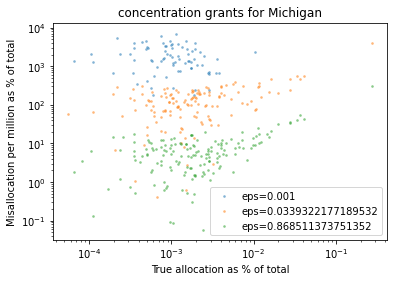

## targeted grants ##
RMSE at eps=0.1048113134154685: 107858.39893504622
RMSE prop eps=0.1048113134154685: 0.011523269918148903
Total misalloc at eps=0.1048113134154685: 758902088.9274589
Total true alloc: 66729811774.698265


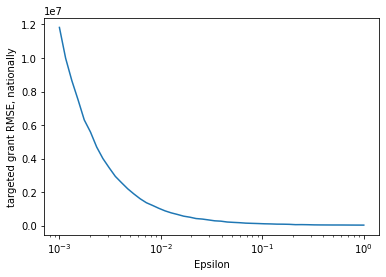

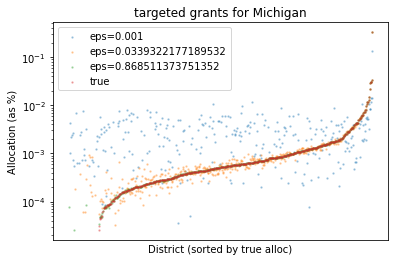

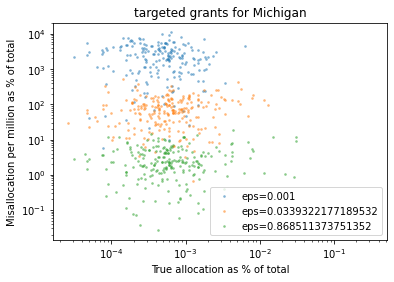

In [57]:
plot_results(results.xs(0.804))

# Discrimination
## Data
Using 2014-2018 ACS race data by school district from the NCES. See notes for more details.
1. Total
2. White alone
3. Black or African American alone
4. American Indian and Alaska Native alone
5. Asian alone
6. Native Hawaiian and Other Pacific Islander alone
7. Some other race alone
8. Two or more races
9. Two or more races: including Some other race
10. Two or more races: excluding Some other race, and three or more races

In [138]:
from dp_policy.titlei.utils import get_race

race = get_race("../data/sd_race18.txt")
race.head()

,,race_1est,race_1moe,race_2est,race_2moe,race_3est,race_3moe,race_4est,race_4moe,race_5est,race_5moe,race_6est,race_6moe,race_7est,race_7moe,race_8est,race_8moe,race_9est,race_9moe,race_10est,race_10moe
State FIPS Code,District ID,,,,,,,,,,,,,,,,,,,,
27,106,5663,242,5576,235,3,4,7,6,8,8,0,12,33,19,36,20,7,7,29,18
45,690,23553,252,16552,217,6325,278,0,23,80,109,0,23,51,43,545,205,52,67,493,206
55,30,3644,247,3339,251,19,15,4,7,8,6,0,9,241,106,33,25,0,9,33,25
48,7380,846,157,813,158,6,9,15,14,0,13,0,13,12,14,0,13,0,13,0,13
6,1620,107256,1060,29011,1494,6685,804,539,224,45448,1356,510,273,20125,1181,4938,747,1923,566,3015,473


In [141]:
saipe = get_saipe("../data/saipe19.xls")
saipe = saipe.join(race, how="inner")
saipe['prop_nonwhitealone'] = 1 - saipe.race_2est / saipe.race_1est

In [147]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting)
error = grants.true_allocation - grants.est_allocation

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


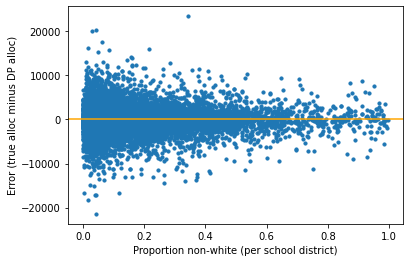

In [152]:
plt.scatter(grants.prop_nonwhitealone, error, s=10)
plt.axhline(y=0, xmin=0, xmax=1, color="orange")
plt.xlabel("Proportion non-white (per school district)")
plt.ylabel("Error (true alloc minus DP alloc)")
plt.show()

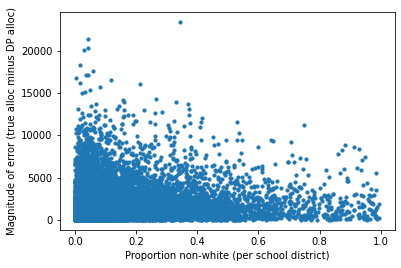

In [154]:
plt.scatter(grants.prop_nonwhitealone, np.abs(error), s=10)
plt.xlabel("Proportion non-white (per school district)")
plt.ylabel("Magnitude of error (true alloc minus DP alloc)")
plt.show()